# Notebook #5 -  Modelling with Scikit-Learn

#### Overview
In this notebook, I will be fitting and optimizing a linear regression model against 3 different target variables: Views, Streams, and Average Monthly Views (YouTube). By doing this, I want to attempt to identify which features of a song have an influence on how popular it is. For example, do songs that rank high in "Danceability" tend to perform better than songs that rank highly in "Instrumentalness"? Could artists and music producers use this to maximize the popularity of their songs?

#### Sections
[1. Data Preparation](#section1)  
[2. Linear Regression](#section2)  
[3. Ridge Regression](#section3)  
[4. Lasso Regression](#section4)  
[5. Decision Tree](#section5)  
[6. Random Forest](#section6)  
[7. XGB Regressor](#section7)  
[8. Model Evaluation](#section8)  
[9. Conclusion](#section9)

---

In [30]:
# Import Standard Libraries
import pandas as pd
import numpy as np

# Import plotting library
import matplotlib.pyplot as plt

# Import ml toolkit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error

# Import linear models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso

# Import Tree based models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [31]:
# Import modelling data
df = pd.read_csv('data/modelling_data.csv')
print(df.shape)
df.head()

(19812, 27)


,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,duration_sec,...,_A#/Bb,_B,_C#/Db,_D,_D#/Eb,_E,_F,_F#/Gb,_G,_G#/Ab
0,0.818,0.705,-6.679,0.1770,0.008360,0.002330,0.6130,0.772,138.559,223,...,0,0,0,0,0,0,0,1,0,0
1,0.676,0.703,-5.815,0.0302,0.086900,0.000687,0.0463,0.852,92.761,200,...,0,0,0,0,0,0,0,0,0,1
2,0.695,0.923,-3.930,0.0522,0.042500,0.046900,0.1160,0.551,108.014,215,...,0,0,1,0,0,0,0,0,0,0
3,0.689,0.739,-5.810,0.0260,0.000015,0.509000,0.0640,0.578,120.423,234,...,0,0,0,1,0,0,0,0,0,0
4,0.663,0.694,-8.627,0.1710,0.025300,0.000000,0.0698,0.525,167.953,341,...,1,0,0,0,0,0,0,0,0,0


In [4]:
# Verify columns in dataframe
df.columns

Index(['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness',
       'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'duration_sec',
       'Views', 'Stream', 'months_published', 'avg_views_per_month',
       '_compilation', '_single', '_A', '_A#/Bb', '_B', '_C#/Db', '_D',
       '_D#/Eb', '_E', '_F', '_F#/Gb', '_G', '_G#/Ab'],
      dtype='object')

---

<a id='section1'></a>
#### Data Preparation

In [58]:
# Fit x & y
X = df.drop(['Views', 'Stream', 'avg_views_per_month'], axis=1)
y = df['Views']

In [33]:
# Split Train & Test sets
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Split validation set
X_train, X_val, y_train, y_val = train_test_split(X_remainder, y_remainder, test_size = 0.25, random_state=42)

In [34]:
# Check shapes
print(f'X_train:{X_train.shape}')
print(f'X_remainder:{X_val.shape}')
print(f'X_test:{X_test.shape}')

X_train:(11886, 24)
X_remainder:(3963, 24)
X_test:(3963, 24)


---

<a id='section2'></a>
#### Linear Regression
I want to start with a baseline linear regression model score to see what we need to improve upon.

In [35]:
# Fit standard linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Save validation score
lr_val_score = lr.score(X_val, y_val) 

# Print R2 score
print(f'Linear Train Score: {lr.score(X_train, y_train)}')
print(f'Linear Validation Score: {lr_val_score}')

Linear Train Score: 0.041788350913312455
Linear Validation Score: 0.027795486613992115


So far, on the base model, we have a terrible R2 score of 0.027 percent, meaning that the current model vaptures very little variance in the data. There is only room for improvement in this circumstance. There are a few approaches I can take to improving the R2 score. 
1. Scale the data
2. Test different models for regression problems
3. Hypertune parameters

It's possible that the datapoints in the dataset available are not overly predictive of the target variable, but that doesn't mean a better model isn't possible. The score to beat is 0.027.

In [36]:
# scale the data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to dataframe
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [37]:
# Refit
lr.fit(X_train, y_train)

# Save validation score
scaled_lr_val_score = lr.score(X_val, y_val)

# Print R2 score
print(f'Linear Train Score: {lr.score(X_train, y_train)}')
print(f'Linear Validation Score: {lr_val_score}')

Linear Train Score: 0.041788350913312455
Linear Validation Score: 0.027795486613992115


In [38]:
# Examine improvement over baseline
print(format(scaled_lr_val_score - lr_val_score, '.20f'))

-0.00000000000000022204


Interesting, the scaled data is returning a slightly worse score than the unscaled data. The change however, is so small, it could be written off as a rounding error. Already I am seeing that so little of the variance is accounted for in the predictor variables that are available to me in this dataset. Moving forward we will be exploring any ways that we can improve model accuracy, even slightly, and understand why the different models would provide a better score.

---

<a id='section3'></a>
#### Ridge Regression (L2 Regularization)

In [12]:
# Instantiate & fit Ridge regressor
ridge = Ridge()
ridge.fit(X_train, y_train)

# Save validation score
ridge_val_score = ridge.score(X_val, y_val)

# Print R2 score
print(f'Ridge Train Score: {ridge.score(X_train, y_train)}')
print(f'Ridge Validation Score: {ridge_val_score}')

Ridge Train Score: 0.041788349737424846
Ridge Validation Score: 0.02779756384547938


In [13]:
# Check improvement over baseline
print(format(ridge_val_score - scaled_lr_val_score, '.20f'))

0.00000207723148748507


Again, a very small improvement to the score. Lets use GridSearchCV to find the best alpha for the ridge regression model (default is 1.0).

In [14]:
# Define parameters of alpha
ridge_parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000]}

# Grid search for best parameters
grid_search_ridge = GridSearchCV(Ridge(), ridge_parameters, cv=5, return_train_score=True)

# Fit
grid_search_ridge.fit(X_train, y_train)

# Extract results for plotting
ridge_train_scores = grid_search_ridge.cv_results_['mean_train_score']
ridge_val_scores = grid_search_ridge.cv_results_['mean_test_score']
 
# Define best estimator
best_ridge = grid_search_ridge.best_estimator_
gs_ridge_val_score = best_ridge.score(X_val, y_val)

# Print best params and score
print(f"Best alpha: {grid_search_ridge.best_params_['alpha']}")
print(f'Train R2: {best_ridge.score(X_train, y_train)}')
print(f'Validation R2: {gs_ridge_val_score}')

Best alpha: 100
Train R2: 0.04177736065925697
Validation R2: 0.027987695956912417


In [15]:
# Check improvement over baseline
print(format(gs_ridge_val_score - ridge_val_score, '.20f'))

0.00019013211143303899


Again, we see a very slight imrpovement when using Ridge regression. 0.0019 increase in validation accuracy. Nothing to write home about. Lets continue exploring models.

---

<a id='section4'></a>
#### Lasso Regression (L1 Regularization)

In [16]:
# Instantiate & fit Ridge regressor
lasso = Lasso()
lasso.fit(X_train, y_train)

# Save validation score
lasso_val_score = lasso.score(X_val, y_val)

# Print R2 score
print(f'Lasso Train Score: {lasso.score(X_train, y_train)}')
print(f'Lasso Validation Score: {lasso_val_score}')

Lasso Train Score: 0.04178835091331168
Lasso Validation Score: 0.02779548843600399


In [17]:
# Compare to default ridge model
print(format(lasso_val_score - ridge_val_score, '.20f'))

-0.00000207540947538831


So default Lasso model performs slightly worse on the validation set than the ridge model.

In [18]:
# Define parameters
lasso_parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000]}

# Grid search for best parameters
grid_search_lasso = GridSearchCV(Lasso(), lasso_parameters, cv=5, return_train_score=True)

# Fit
grid_search_lasso.fit(X_train, y_train)

# Extract results for plotting
lasso_train_scores = grid_search_lasso.cv_results_['mean_train_score']
lasso_val_scores = grid_search_lasso.cv_results_['mean_test_score']

# Define best estimator
best_lasso = grid_search_lasso.best_estimator_
gs_lasso_val_score = best_lasso.score(X_val, y_val)

# Print best params and score
print(f"Best alpha: {grid_search_lasso.best_params_['alpha']}")
print(f'Train R2: {best_lasso.score(X_train, y_train)}')
print(f'Validation R2: {gs_lasso_val_score}')

Best alpha: 1000
Train R2: 0.0417883501647901
Validation R2: 0.027797307937793447


In [19]:
# Check improvement over baseline
print(format(gs_lasso_val_score - lasso_val_score, '.20f'))

0.00000181950178945733


In [20]:
# Compare lasso to ridge
print(format(gs_lasso_val_score - gs_ridge_val_score, '.20f'))

-0.00019038801911896996


That's no better than Ridge regression. I think it would be helpful to plot out the train and test scores for the two models to understand the impact the parameters are having on performance.

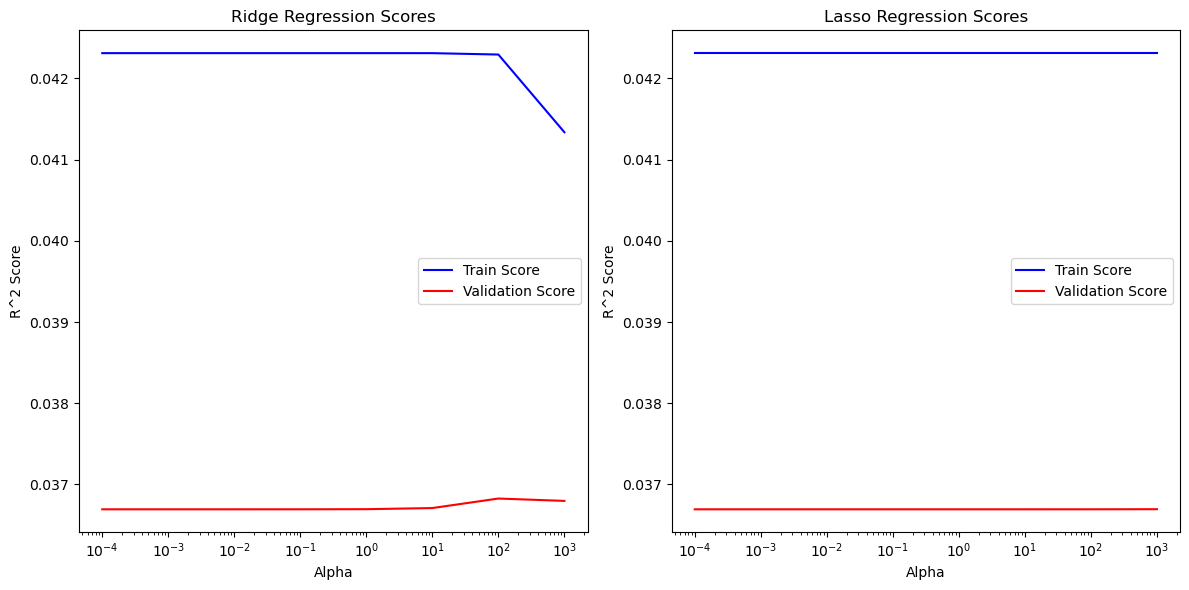

In [21]:
# Instantiate plot
plt.figure(figsize=(12,6))

# Ridge scores
plt.subplot(1, 2, 1)
plt.plot(ridge_parameters['alpha'], ridge_train_scores, label='Train Score', color='b')
plt.plot(ridge_parameters['alpha'], ridge_val_scores, label='Validation Score', color='r')
plt.title('Ridge Regression Scores')
plt.ylabel('R^2 Score')
plt.xlabel('Alpha')
plt.xscale('log')
plt.legend()

# Ridge scores
plt.subplot(1, 2, 2)
plt.plot(ridge_parameters['alpha'], lasso_train_scores, label='Train Score', color='b')
plt.plot(ridge_parameters['alpha'], lasso_val_scores, label='Validation Score', color='r')
plt.title('Lasso Regression Scores')
plt.ylabel('R^2 Score')
plt.xlabel('Alpha')
plt.xscale('log')
plt.legend()

plt.tight_layout()
plt.show()

From the above plots, I can see that the Ridge Regression scores stay more or less the same until alpha = 100, which returns a slightly improved validation score and the training score drops off.  
It looks as though there is very little impact to the scores with different parameters in the Lasso Regression model. Lasso regression is typically used to avoid instances of overfitting. I think given the incredibly poor score of the model, it is fair to say that the model is definitely not overfitting.

At this point, I think it's fair to say that the standard linear model with different methods of regularization are not overly effective in predicting the number of YouTube views a song may get based on the predictor variables we have. Now I want to try some tree based models. 

---

<a id='section5'></a>
#### Decision Tree

In [21]:
# Establish baseline model
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

# Save validation score
tree_val_score = tree.score(X_val, y_val)

# Print R2 scores
print(f'Decision Tree Train Score:{tree.score(X_train, y_train)}')
print(f'Decision Tree Validation Score:{tree_val_score}')

Decision Tree Train Score:0.9996461815119477
Decision Tree Validation Score:-1.2149857341916825


Wow, the default decision tree model performs incredibly poorly, overfitting the training data and making a really poor prediction on the validation set. Lets see if we can't improve this models performance by tuning the following parameters:
- max_depth (default: None)
- min_samples_split (default: 2)
- min_samples_leaf (default: 1)
- max_features (default: None)  

First, I want to examine how different depths affect the train and validation scores.

In [22]:
# Assign a depth range
max_depths = range(1, 51, 2) 

# Instantiate accuracy lists
train_acc = []
validation_acc = []

# Loop through depths to get accuracy scores
for depth in max_depths:
    # Instantiate model & fit
    tree = DecisionTreeRegressor(max_depth=depth)
    tree.fit(X_train, y_train)
    
    # Score the model
    train_accuracy = tree.score(X_train, y_train)
    validation_accuracy = tree.score(X_val, y_val)
    
    # Append scores to lists
    train_acc.append(train_accuracy)
    validation_acc.append(validation_accuracy)

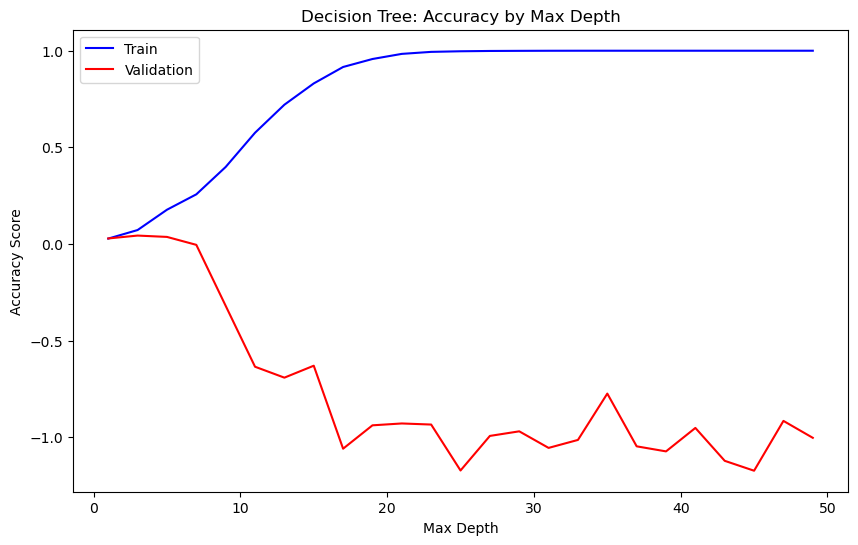

In [23]:
# Instantiate plot
plt.figure(figsize=(10,6))

# Plot values
plt.plot(max_depths, train_acc, color='blue', label='Train')
plt.plot(max_depths, validation_acc, color='red', label='Validation')

# Label the plot
plt.title('Decision Tree: Accuracy by Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy Score')
plt.legend()

plt.show()

I can see from the above plot that the train and validation scores diverge pretty quickly from eachother. It also looks as though the train score approaches 100% around an max depth of 20. What I'll do next is use grid search to find the best parameters for the Decision Tree Regresso, but limit the max_depth to 20.

In [24]:
# Define parameters
parameters = {
    'max_depth': range(1, 21, 2),
    'min_samples_split': range(1, 101, 10),
    'min_samples_leaf': range(1, 101, 10),
    'max_features': [None, 'sqrt', 'log2']
}

# Grid search for best parameters
grid_search_tree = GridSearchCV(tree, parameters, cv=5, scoring='r2', return_train_score=True)

# Fit
grid_search_tree.fit(X_train, y_train)

# Define best estimator
best_tree = grid_search_tree.best_estimator_
gs_tree_val_score = best_tree.score(X_val, y_val)

In [25]:
# Print best params and score
print(f"Best tree parameters: {grid_search_tree.best_params_}")
print(f'Train R2: {best_tree.score(X_train, y_train)}') 
print(f'Validation R2: {gs_tree_val_score}')

Best tree parameters: {'max_depth': 7, 'max_features': None, 'min_samples_leaf': 81, 'min_samples_split': 11}
Train R2: 0.13718563508350679
Validation R2: 0.05441125532764224


That score is much better than the default decision tree model!

In [26]:
print(format(gs_tree_val_score - gs_ridge_val_score, '.20f'))

0.02642355937072982108


Not only that, but it's nearly twice as accurate than the ridge regression model! An improvement of 0.0264 in the validation accuracy score!

---

<a id='section6'></a>
#### Random Forest

In [27]:
# Establish baseline model
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# Save validation score
rf_val_score = rf.score(X_val, y_val)

# Print R2 scores
print(f'Random Forest Train Score:{rf.score(X_train, y_train)}')
print(f'Random Forest Validation Score:{rf_val_score}')

Random Forest Train Score:0.8829262914880269
Random Forest Validation Score:0.142709729479358


This baseline model is producing the best result I've found so far with a validation score of ~14%. Before moving onto hyper parameter optimization, I want to again test the scores by max_depth so as to not waste time computing models at a depth that won't provide improvement in model accuracy.

In [28]:
# Assign a depth range
max_depths = range(1, 51, 2) 

# Re-instantiate accuracy lists
train_acc = []
validation_acc = []

# Loop through depths to get accuracy scores
for depth in max_depths:
    # Instantiate model & fit
    rf = RandomForestRegressor(max_depth=depth)
    rf.fit(X_train, y_train)
    
    # Score the model
    train_accuracy = rf.score(X_train, y_train)
    validation_accuracy = rf.score(X_val, y_val)
    
    # Append scores to lists
    train_acc.append(train_accuracy)
    validation_acc.append(validation_accuracy)

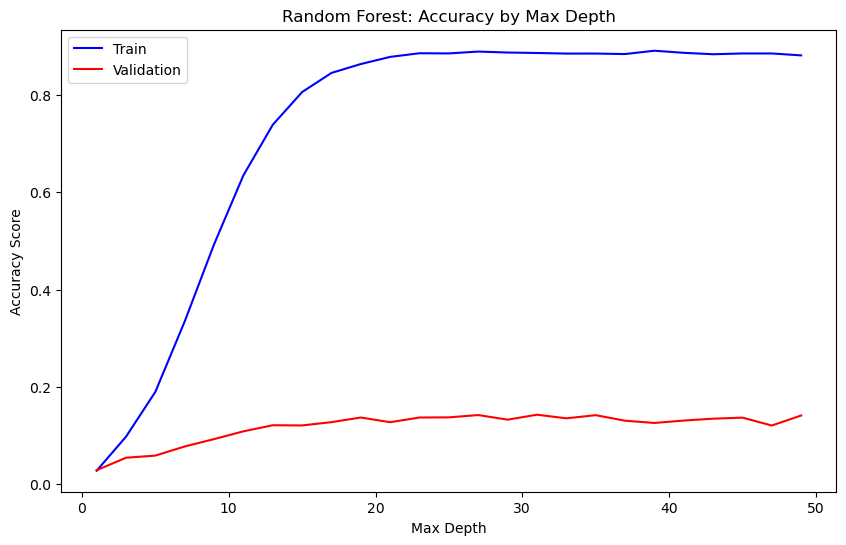

In [29]:
# Instantiate plot
plt.figure(figsize=(10,6))

# Plot values
plt.plot(max_depths, train_acc, color='blue', label='Train')
plt.plot(max_depths, validation_acc, color='red', label='Validation')

# Label the plot
plt.title('Random Forest: Accuracy by Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy Score')
plt.legend()

plt.show()

Similar to the decision tree model, the train score stops improving around a max depth of 20. When performing a grid search, I need to generalize some of the parameters so as to save on computation time. Some of the models are very computationally expensive. While I would like to evaluate every value in a range to get the best out of model performance, I notice that I'm having to make some concessions to how many parameters I am testing.

In [30]:
# Define model parameters 
parameters = {
    'n_estimators': [50, 100, 150],
    'max_depth': range(2, 21, 2),
    'min_samples_split': [2, 10, 20, 50, 100],
    'min_samples_leaf': [1, 10, 20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Grid search for best parameters
grid_search_rf = GridSearchCV(rf, parameters, cv=5, scoring='r2', return_train_score=True)

# Fit
grid_search_rf.fit(X_train, y_train)

# Define best estimator
best_rf = grid_search_rf.best_estimator_
gs_rf_val_score = best_rf.score(X_val, y_val)

In [31]:
# Print best params and score
print(f"Best random forest parameters: {grid_search_rf.best_params_}")
print(f'Train R2: {best_rf.score(X_train, y_train)}')
print(f'Validation R2: {gs_rf_val_score}')

Best random forest parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Train R2: 0.8619581963753242
Validation R2: 0.19696749039543826


19.6% is the best validation accuracty score yet. The model also performs better with a higher number of estimators (150) than the default value (100).

---

<a id='section7'></a>
#### Gradient Boosted Tree (Extreme Gradient Boosting Regressor)

In [32]:
# Establish baseline model
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

# Save validation score
xgb_val_score = xgb.score(X_val, y_val)

# Print R2 scores
print(f'Random Forest Train Score:{xgb.score(X_train, y_train)}')
print(f'Random Forest Validation Score:{xgb_val_score}')

Random Forest Train Score:0.8545772317962368
Random Forest Validation Score:0.0988187610367196


A 9.8% validation score is much better than some of the other models. Not quite as strong as the baseline random forest model. [This page](https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning) on Kaggle was particularly helpful in helping my comprehension with the hyperparameters in XGBoost.

In [33]:
# Define parameters for XGB Regressor
parameters = {
    'learning_rate': [0.5, 0.1],
    'n_estimators': [50, 100, 150],
    'max_depth': range(5, 21, 5),
    'min_child_weight': [1, 5, 10],
    'subsample': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.75, 1],
    'reg_lambda': [0.01, 0.1, 1, 10],
    'reg_alpha': [0.01, 0.1, 1, 10]
}

# Grid search for best parameters
grid_search_xgb = GridSearchCV(xgb, parameters, cv=5, scoring='r2', return_train_score=True)

# Fit
grid_search_xgb.fit(X_train, y_train)

# Define best estimator
best_xgb = grid_search_xgb.best_estimator_
gs_xgb_val_score = best_xgb.score(X_val, y_val)

In [34]:
# Print best params and score
print(f"Best XGBoost parameters: {grid_search_xgb.best_params_}")
print(f'Train R2: {best_xgb.score(X_train, y_train)}')
print(f'Validation R2: {gs_xgb_val_score}')

Best XGBoost parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 10, 'reg_lambda': 10, 'subsample': 1}
Train R2: 0.853110326928715
Validation R2: 0.17385379640535914


This grid search took a very long time to run. I would like to fine tune more parameters, but the computation time is very intensive and would take too long to fully explore, with no guaruntee that it would improve model performance. Lets evaluate all of the models next to eachother now.

---

<a id='section8'></a>
#### Model Evaluation

In [40]:
# Print accuracies
print(f'Linear Regression Accuracy:{lr_val_score}')
print(f'Ridge Regression Accuracy:{gs_ridge_val_score}')
print(f'Lasso Regression Accuracy:{gs_lasso_val_score}')
print(f'Decision Tree Accuracy:{gs_tree_val_score}')
print(f'Random Forest Accuracy:{gs_rf_val_score}')
print(f'EXB Regressor Accuracy:{gs_xgb_val_score}')

Linear Regression Accuracy:0.027795486613992115
Ridge Regression Accuracy:0.027987695956912417
Lasso Regression Accuracy:0.027797307937793447
Decision Tree Accuracy:0.05441125532764224
Random Forest Accuracy:0.19696749039543826
EXB Regressor Accuracy:0.17385379640535914


The Random Forest model performs the best, capturing ~19% of the variance in the R2 score of the model. 

In [45]:
# Instantiate a model score dictionary
score_dict = {
    'Linear Regression': lr_val_score,
    'Ridge Regression': gs_ridge_val_score,
    'Lasso Regression': gs_lasso_val_score,
    'Decision Tree': gs_tree_val_score,
    'Random Forest': gs_rf_val_score,
    'XGB Regressor': gs_xgb_val_score
}

# Verify
score_dict

{'Linear Regression': 0.027795486613992115,
 'Ridge Regression': 0.027987695956912417,
 'Lasso Regression': 0.027797307937793447,
 'Decision Tree': 0.05441125532764224,
 'Random Forest': 0.19696749039543826,
 'XGB Regressor': 0.17385379640535914}

In [39]:
# Compute mean absolute error of each model
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=100),
    'Lasso Regression': Lasso(alpha=1000),
    'Decision Tree': DecisionTreeRegressor(max_depth=7, min_samples_leaf=81, min_samples_split=11),
    'Random Forest': RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=150),
    'XGB Regressor': XGBRegressor(colsample_bytree=0.5, learning_rate=0.1, max_depth=10, min_child_weight=1,
                                  n_estimators=100, reg_alpha=10, reg_lambda=10, subsample=1)
}

mae_scores = []

# Predict & compute MAE
for name, model, in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    mae = mean_absolute_error(y_val, predictions)
    print(f'{name}: MAE = {mae:.2f}')

Linear Regression: MAE = 117628962.90
Ridge Regression: MAE = 117542834.24
Lasso Regression: MAE = 117628465.74
Decision Tree: MAE = 110694316.69
Random Forest: MAE = 103416178.00
XGB Regressor: MAE = 100892738.31


Given the substantial number of views being predicted, the MAE scoers are understandably quite high. In terms of R^2 score, the Random Forest model outperforms the XGB Regressor, but in the context of mean absolute error, the XGB regressor is superior to the Random Forest model.

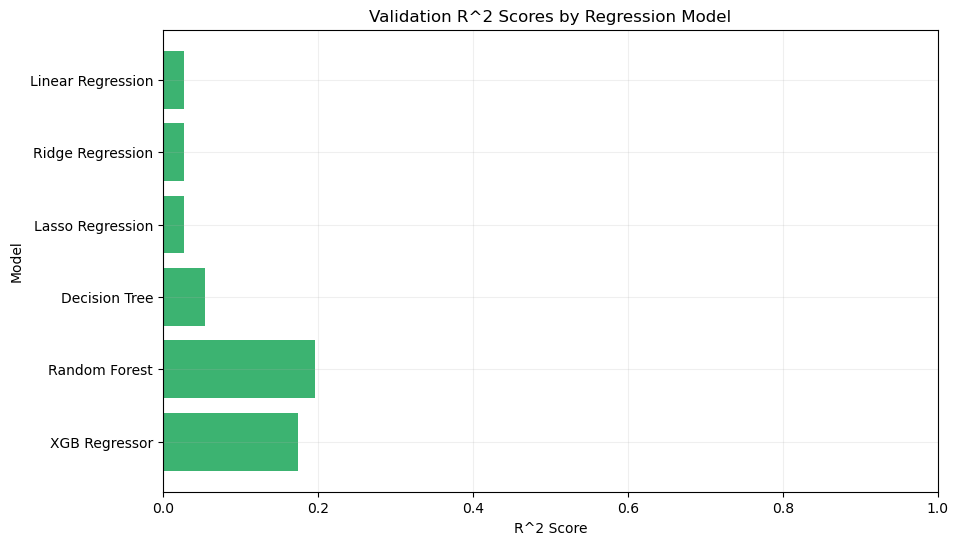

In [57]:
# Plot the scores of the different models
models = list(score_dict.keys())
scores = list(score_dict.values())

plt.figure(figsize=(10,6))
plt.barh(models, scores, color='mediumseagreen')
plt.title('Validation R^2 Scores by Regression Model')
plt.ylabel('Model')
plt.xlabel('R^2 Score')
plt.xlim(0, 1)
plt.grid(alpha=0.2)
plt.gca().invert_yaxis()
plt.show()

Above, we can see that the Random Forest model performed the best out of all the models with the following parameters:
- max_depth: 20
- max_features: sqrt
- min_samples_leaf: 1
- min_samples_split: 2
- n_estimators: 150

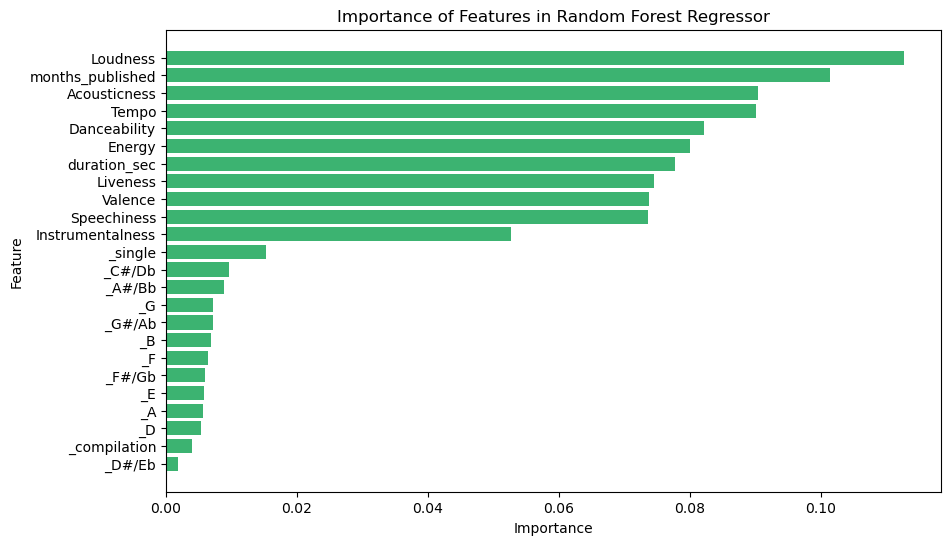

In [57]:
# Examine feature_importances in model
rf_optimal = RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=150)
rf_optimal.fit(X_train, y_train)

# Extract importances
importances = rf.feature_importances_

importance_df = pd.DataFrame({'Feature': X.columns,
                              'Importance': importances
                             })

# Sort
importance_df = importance_df.sort_values(by='Importance')

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='mediumseagreen')
plt.title('Importance of Features in Random Forest Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.show()

In the above barplot, we can see that features like "Loudness" and "Number of Months Published", are most important in making predictions with Random Forest Regressor, wherase features like the key, or the album type, which were one-hot encoded in the feature engineering stage are not as imporant. Of the album types, it looks like "singles" tend to be most predictive of that type, however.  

These features, by importance, serve as a good reference point for where an artist or producer could start their evaluation process of a song prior to releasing it.

In [63]:
# Instantiate random forest model with optimal hyperparameters
rf_optimal = RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=150)
rf_optimal.fit(X_train, y_train)

# Print R2 scores
print(f'Random Forest Train Score:{rf_optimal.score(X_train, y_train)}')
print(f'Random Forest Test Accuracy:{rf_optimal.score(X_test, y_test)}')

Random Forest Train Score:0.8686079951639515
Random Forest Test Accuracy:0.18195186375110828


---

<a id='section9'></a>
#### Conclusion
The R^2 score of 18.2% (Random Forest) indicates that the model explains 18.2% of the variance in the test data. This is a significant improvement from the 2.7% offered by the linear regression model. The modest scores suggest the limitations of only using musical features to predict a song's popularity. While these features are undoubtedly significant, the popularity of a song is not only determined by such features. Factors such as genre, which isn't available in the current dataset, might contribute meaningfully.

In the context of mean absolute error, the XGB Regressor makes the best predictions. The large MAE score is also very likely held back by the limitations in the data. With access to more data, the performance of both models could be further improved and re-evaluated. 

Moreover, external elements like the artist's reputation and their existing fanbase can substantially influence the number of views a song gets. That said, this project's intent was to isolate and assess the influence of musical features, independent of the artist behind the song. As such, I see a model explaining almost 20% of the variance to be a success, and I'm confident that, given more time to collect additional data, like genre, and test more models would yield a much higher R^2 score.

---